# Ridge Regression

Ridge Regression (also called **Tikhonov Regularization**) is a modified version of linear regression that adds an **L2 penalty** to the loss function. This penalty constrains the size of the coefficients, helping to prevent overfitting, especially in the presence of **multicollinearity** or **high-dimensional data**.

### Why Do We Constrain the Weights?

In ordinary linear regression, the goal is to minimize the sum of squared errors. However, when predictors are highly correlated or when we have many features compared to the number of observations, the estimated coefficients can become very large and unstable.

**Constraining the weights serves two main purposes:**

- ✅ Reduces model variance and improves generalization to unseen data  
- ✅ Prevents the model from fitting noise in the training set (overfitting)

Regularization imposes a penalty on large coefficients, effectively **controlling model complexity**.

### Ridge Regression Objective Function

The cost function minimized by Ridge Regression is:

$$
\min_{\beta} \left\{ 
\sum_{i=1}^{n} \left( y_i - \beta_0 - \sum_{j=1}^{p} x_{ij} \beta_j \right)^2
+ 
\lambda \sum_{j=1}^{p} \beta_j^2
\right\}
$$

Where:
- $\beta_j$ are the model coefficients (weights)  
- $\lambda \ge 0$ is the regularization strength  
- The term $\sum_{j=1}^{p} \beta_j^2$ is the **L2 penalty**

**Effect:**  
🔹 Coefficients are shrunk towards zero (but never exactly zero)  
🔹 The model retains all features but reduces their influence if they are not strongly predictive


### Ridge vs Lasso (Why Ridge Does *Not* Eliminate Features)

| Method      | Penalty Type | Shrinks Coefficients | Sets Coefficients Exactly to Zero | Feature Selection |
|-------------|--------------|----------------------|-----------------------------------|------------------|
| **Ridge**   | L2 (squared) | ✅ Yes               | ❌ No                             | ❌ No            |
| **Lasso**   | L1 (absolute)| ✅ Yes               | ✅ Yes                            | ✅ Yes           |

- **Ridge** is ideal when many features are expected to have a small but non-zero effect.
- **Lasso**, in contrast, can completely eliminate coefficients, effectively removing features from the model.


---

## 1. Data Generation

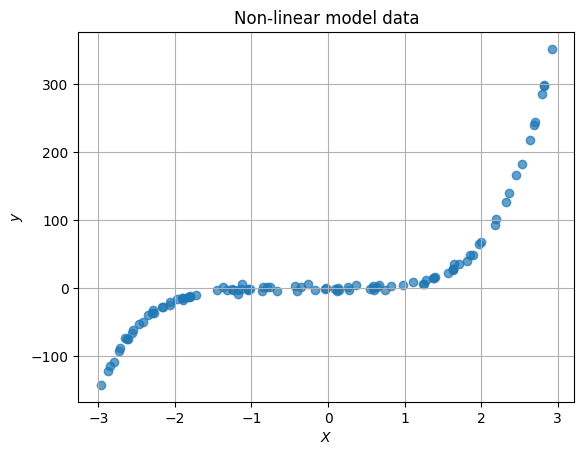

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

n_samples = 100
X = np.sort(np.random.rand(n_samples, 1) * 6 - 3, axis=0)
y = 1.5 * X**4 + X**5 + X**3 + X + np.random.randn(n_samples, 1) * 3

plt.scatter(X, y, alpha=0.7)
plt.title("Non-linear model data")
plt.xlabel("$X$")
plt.ylabel("$y$")
plt.grid(True)
plt.show()

## 2. Polynomial caractheristics construction

We apply a polynomial transformation here to enable our linear model to capture a non-linear relationship.

In [2]:
def polynomial_features(X, degree):
    X_poly = np.ones((X.shape[0], degree + 1))
    for d in range(1, degree + 1):
        X_poly[:, d] = X[:, 0] ** d
    return X_poly

In [3]:
degree = 5
X_poly = polynomial_features(X, degree)

---

## 3. Ridge from scratch

In [4]:
def ridge_regression(X, y, alpha):
    n_features = X.shape[1]
    I = np.eye(n_features)
    return np.linalg.inv(X.T @ X + alpha * I) @ X.T @ y

# Example with alpha = 0.1
alpha = 0.1
theta_ridge = ridge_regression(X_poly, y, alpha)

# Printing coefficients
for i, coef in enumerate(theta_ridge.flatten()):
    print(f"θ_{i} = {coef:.4f}")

θ_0 = -0.1291
θ_1 = 0.3063
θ_2 = 0.1688
θ_3 = 1.3742
θ_4 = 1.4786
θ_5 = 0.9652


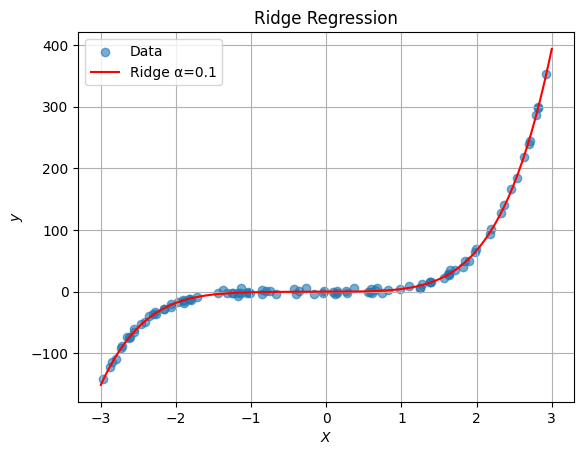

In [5]:
X_plot = np.linspace(-3, 3, 200).reshape(-1, 1)
X_plot_poly = polynomial_features(X_plot, degree)
y_pred = X_plot_poly @ theta_ridge

plt.scatter(X, y, alpha=0.6, label="Data")
plt.plot(X_plot, y_pred, color='red', label=f"Ridge α={alpha}")
plt.xlabel("$X$")
plt.ylabel("$y$")
plt.legend()
plt.grid(True)
plt.title("Ridge Regression")
plt.show()

---

## 4. Ridge with Scikit-learn

### 🔧 Important Parameters of Ridge Regression

#### **alpha** *(float or ndarray, default = 1.0)*
- Controls the strength of the L2 regularization.
- A larger value strongly penalizes the size of coefficients, which **reduces variance** (less overfitting) but may **increase bias**.
- It is recommended to test multiple values of `alpha` to find the right balance between bias and variance.

#### **fit_intercept** *(bool, default = True)*
- Determines whether to calculate the intercept (bias term).
- If set to `False`, the regression line is forced to pass through the origin (no intercept is fitted).

#### **solver** *(str, default = 'auto')*
- Specifies the algorithm used to solve the optimization problem.
- Examples include: `'svd'`, `'cholesky'`, `'sag'`, `'sparse_cg'`, etc.
- When set to `'auto'`, the solver is chosen automatically based on the size and structure of the data.


### Deep Dive: `solver` Parameter in Ridge Regression

The `solver` parameter controls the algorithm used to optimize the Ridge Regression objective function. Different solvers are better suited depending on the **size of the dataset**, **sparsity**, **number of features**, or whether the data is **dense or sparse**.

Choosing the right solver can impact:
- **Training speed**
- **Numerical stability**
- **Memory usage**

### Available Solvers and Their Use Cases

| Solver       | Description | Best Use Case | Supports Sparse Data | Notes |
|--------------|-------------|---------------|----------------------|-------|
| **'auto'**   | Automatically selects the best solver based on data | Recommended default | Yes | Lets the library (scikit-learn) choose the most efficient method |
| **'svd'**    | Uses Singular Value Decomposition | Suitable for small to medium dense datasets | No | Numerically stable and does not require alpha tuning via gradient descent |
| **'cholesky'** | Uses Cholesky decomposition | Very fast on small datasets with full rank | No | Can fail if matrix is not positive definite |
| **'lsqr'**   | Uses Least Squares via iterative methods | Large datasets, dense or sparse | Yes | Faster and more memory efficient than SVD on large problems |
| **'sparse_cg'** | Conjugate Gradient method | Large-scale sparse datasets | Yes | Iterative method that handles high-dimensional data efficiently |
| **'sag'**    | Stochastic Average Gradient | Very large datasets with many samples | Yes | Requires features to be standardized; good for online/streaming data |
| **'saga'**   | Variant of SAG that supports L1 and L2 | Very large datasets with L1/L2 regularization | Yes | Can be used when mixing Ridge with other penalties |

---

### How to Choose the Right Solver

#### Use `auto` unless you have a specific reason.
It will pick the best option based on the dataset's characteristics.

#### Guidelines by scenario:

- **Small and dense dataset:**  
  → Use `'svd'` or `'cholesky'` for speed and accuracy.

- **Large number of features or sparse matrices:**  
  → `'sparse_cg'` or `'lsqr'` are preferred.

- **Very large datasets (millions of samples):**  
  → `'sag'` or `'saga'` with standardized features.

- **Need compatibility with L1 or ElasticNet regularization in the future:**  
  → Use `'saga'`.


### alpha parameter variations

In [10]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

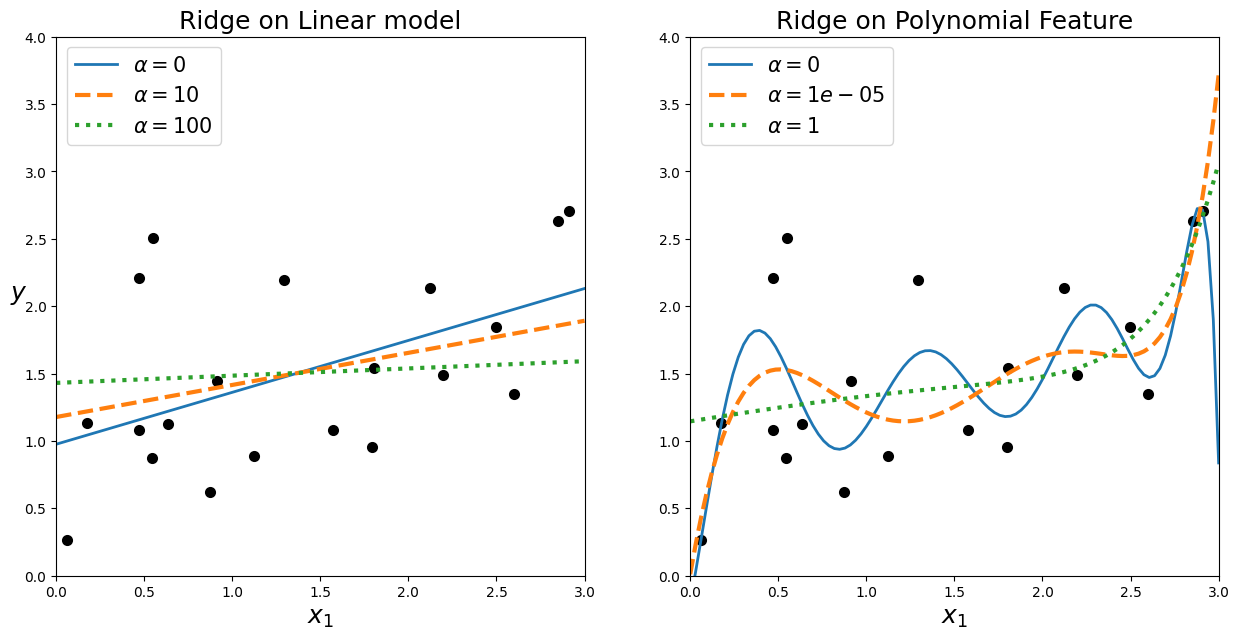

In [8]:
def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("-", "--", ":")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 3 if alpha > 0 else 2
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.scatter(X, y, color='k', linewidth=2)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(15,7))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.title("Ridge on Linear model", fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)
plt.title("Ridge on Polynomial Feature", fontsize=18)
plt.show()

### What Do We Observe?

By varying `alpha`, we can clearly see the effect of regularization:

- **Small alpha (0.1):**  
  The solution is close to ordinary linear regression, fitting the data closely. *(Potential risk of overfitting)*

- **Intermediate alpha (1 to 10):**  
  A good compromise, controlling the coefficients while still capturing the overall trend.

- **Large alpha (100):**  
  Regularization is too strong, the regression line becomes almost flat, leading to significant underfitting.

**Conclusion:**  
The strength of Ridge lies in its ability to **balance bias and variance** by tuning `alpha` appropriately.


### RidgeCV: Automatic Selection of Alpha via Cross-Validation

`RidgeCV` automates the selection of the hyperparameter `alpha` using internal cross-validation.


### Key Additional Parameters

- **alphas**: List of values to test during cross-validation.  
- **scoring**: Metric used to select the optimal `alpha` (e.g., `'neg_mean_squared_error'`, `'r2'`, etc.).  
- **cv**: Cross-validation strategy (if `None`, uses Leave-One-Out by default).


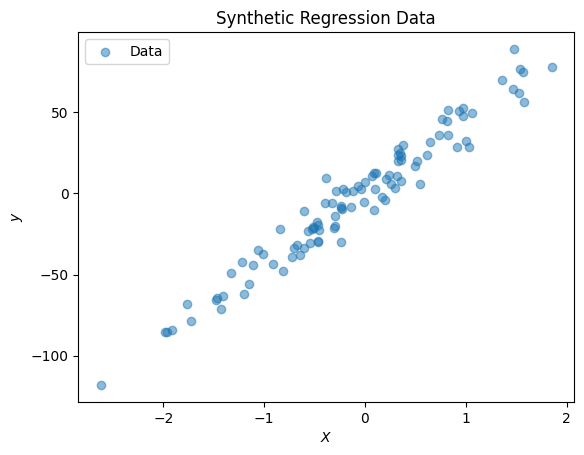

In [12]:
from sklearn.datasets import make_regression

np.random.seed(0)
X, y = make_regression(n_samples=100, n_features=1, noise=10.0, random_state=42)

plt.scatter(X, y, alpha=0.5, label="Data")
plt.title("Synthetic Regression Data")
plt.xlabel("$X$")
plt.ylabel("$y$")
plt.legend()
plt.show()

Best parameters with cross-validation : 0.10


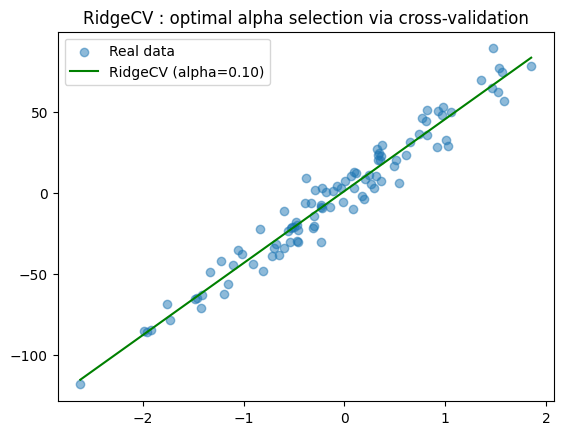

In [13]:
from sklearn.linear_model import RidgeCV

# RidgeCV with cross-validation to select the best alpha
ridge_cv = RidgeCV(alphas=[0.01, 0.1, 1, 10, 100], scoring='r2', cv=5)
ridge_cv.fit(X, y)

print(f"Best parameters with cross-validation : {ridge_cv.alpha_:.2f}")

# Visualisation
plt.scatter(X, y, alpha=0.5, label='Real data')
X_sorted = np.sort(X, axis=0)
plt.plot(X_sorted, ridge_cv.predict(X_sorted), color='green', label=f'RidgeCV (alpha={ridge_cv.alpha_:.2f})')
plt.title('RidgeCV : optimal alpha selection via cross-validation')
plt.legend()
plt.show()

### What Do We Observe with RidgeCV?

`RidgeCV` automatically identifies the best `alpha` based on the data, without the need for manual external cross-validation.

Here, the optimal value selected via internal cross-validation achieves a good balance between model complexity and performance, avoiding overfitting while preventing the model from being too simplistic.

**Conclusion:**  
RidgeCV is therefore a powerful and convenient tool, especially useful when the appropriate `alpha` is unknown.
